# Nerual Style Transfer

Neural Style Transfer (NST) merges two images-*content* image and a *style* image-to create a *generated* image. The algorithm was created by [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576)

### An Example
An example from [*TensorFlow Implementation of "A Neural Algorithm of Artistic Style,"*](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style) merging the style of *Guernica* to Hong Kong's Peak Tram.  
![style and content](images/hongkong-guernica-side-by-side.jpg)   
![output](images/hongkong-painted.png)

In [1]:
import time
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False

from nst_utils import *

### The Model
A VGG-19 network, pretrained on ImageNet. Take the model from tf.keras.applications and extract the needed layers.

In [2]:
def vgg_layers(layer_names):
    """Create a VGG model that returns a list of intermediate output values."""
    # load pretrained model
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    # extract outputs
    outputs = [vgg.get_layer(name).output for name in layer_names]
    # build the model
    model = tf.keras.Model([vgg.input], outputs)
    return model


class StyleContentModel(tf.keras.models.Model):
    """Returns the style and content tensors."""
    def __init__(self, style_layers=STYLE_LAYERS, content_layers=CONTENT_LAYERS):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        """
        Reapply all ops in the graph to the new inputs and extract style
        and content layers.
        """
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        # extract outputs and split results between `style` and `content`
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        content_dict = { content_name: value
                         for content_name, value
                         in zip(self.content_layers, content_outputs) }

        style_dict = { style_name: value
                       for style_name, value
                       in zip(self.style_layers, style_outputs) }

        return { 'content': content_dict, 'style': style_dict }


### The Content

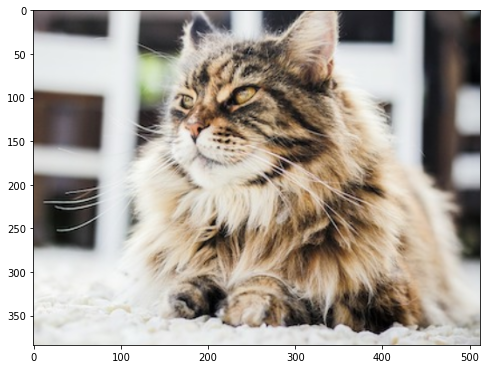

In [3]:
content_image = load_img('images/persian_cat.jpg')
imshow(content_image)

### The Style

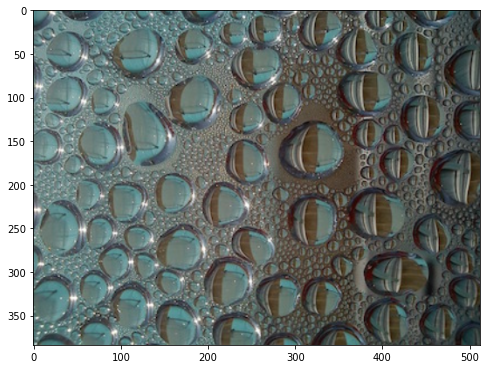

In [4]:
style_image = load_img('images/drop-of-water.jpg')
imshow(style_image)

### Loss Function
The total loss is a combination of the content loss and style cost. The content cost roughly measures the similarity of the content image and the generated image. The style cost uses the results from multiple layers, comparing non-local information accross channels using *Gram* matrices.

In [12]:
# The layer parameters
content_layers = CONTENT_LAYERS
style_layers = STYLE_LAYERS
#style_weights = STYLE_WEIGHTS
style_weights = [0.25, 0.5, 1.0, 2.0, 4.0]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# content weight
alpha = 10.0

# style weight
beta = 0.5

In [13]:
def loss_function(outputs, targets):
    """Compute and combine content and style losses."""
    
    def _content_loss(outputs, targets):
        """
        Compute content loss ~ measure similarity between 
        content and generated image.
        """
        # Only set up for one content layer
        # extract tensors
        _, a_C = list(targets.items())[0]
        _, a_G = list(outputs.items())[0]
        # extract dims
        n, n_H, n_W, n_C = a_G.get_shape().as_list()
        
        # compute loss 
        J_content = (1 / (4 * n_H * n_W * n_C)) * \
            tf.reduce_sum(
                tf.square(
                    tf.subtract(a_C, a_G)))
        return J_content
    
    def _gram_matrix(A):
        """Return the gram matrix G of the input A."""
        # extract dims
        m, n_H, n_W, n_C = A.get_shape().as_list()
        # reshape to 2-D with channels first
        A = tf.transpose(tf.reshape(A, [-1, n_C]))
        # compute A * A_transposed
        G = tf.matmul(A, tf.transpose(A))
        return G
    
    def _style_loss(outputs, targets, weights):
        """Compute weighted average of loss over the style layers."""
        
        def _layer_style_loss(a_S, a_G):
            """Compute style loss for a hidden layer."""
            # extract dims
            m, n_H, n_W, n_C = a_G.get_shape().as_list()
            # get gram matrices
            GS = _gram_matrix(a_S)
            GG = _gram_matrix(a_G)
            # compute loss
            J_layer_style = (1 / (np.product(np.square([2, n_H, n_W, n_C])))) * \
                tf.reduce_sum(
                    tf.square(
                        tf.subtract(GS, GG)))
            return J_layer_style
        
        # initialize total style cost
        J_style = 0
        for layer_name in outputs.keys():
            a_S = targets[layer_name]
            a_G = outputs[layer_name]
            W   = weights[layer_name]
            J_layer_style = W * _layer_style_loss(a_S, a_G)
            J_style += J_layer_style
        J_style = J_style / num_style_layers
        return J_style
    # separate style and content data
    style_outputs, content_outputs = outputs['style'], outputs['content']
    style_targets, content_targets = targets['style'], targets['content']
    
    # set the parameters
    weights = { name:value for name, value in zip(style_layers, style_weights) }
    
    # compute components
    J_content = _content_loss(content_outputs, content_targets)
    J_style   = _style_loss(style_outputs, style_targets, weights)
    
    # combine
    J = alpha * J_content + beta * J_style
    
    return J

### Global training variables

In [14]:
model = StyleContentModel()

content_targets = model(content_image)['content']
style_targets = model(style_image)['style']
targets = { 'content': content_targets, 'style': style_targets }

image = tf.Variable(content_image)

### Optimization

In [15]:
# Adam parameters
learning_rate = LEARNING_RATE
beta_1 = BETA_1
epsilon = EPSILON

opt = tf.optimizers.Adam(learning_rate, beta_1, epsilon)

### Training

In [16]:
@tf.function()
def train_step(image):
    """A single step of NST"""
    with tf.GradientTape() as tape:
        outputs = model(image)
        loss = loss_function(outputs, targets)
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


def fit(epochs=10, steps_per_epoch=100):
    """Iterate the training and `fit` the image to style and content."""
    display.display(tensor_to_image(image))
    start = time.time()
    step = 0
    for n in range(epochs):
        for m in range(steps_per_epoch):
            step += 1
            train_step(image)
            print('.', end='')
        display.clear_output(wait=True)
        display.display(tensor_to_image(image))
        print("Train step: {}".format(step))
        #save_img(OUTPUT_PATH + 'step_' + str(step) + '.jpg', image)
    t = time.time() - start
    h = int(t / 3600)
    t -= h * 36
    m = int(t / 60)
    t -= m * 60
    save_img(OUTPUT_PATH + 'generated_image.jpg', image)
    print("Total time: {:02d}:{:02d}:{:02.2f}".format(h, m, t))

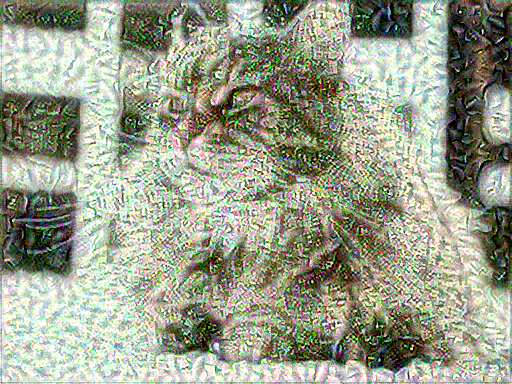

Train step: 20
Total time: 00:01:38.84


In [17]:
fit(epochs = 4, steps_per_epoch = 5)

### References
  + Art_Generation_with_Neural_Style_Transfer_v3a.ipynb from DeepLearning.ai.
  + The TensorFlow tutorial [Neural Style Transfer](https://www.tensorflow.org/tutorials/generative/style_transfer). 
  + From github user log0:  
    - [TensorFlow Implementation of "A Neural Algorithm of Artistic Style"](http://www.chioka.in/tensorflow-implementation-neural-algorithm-of-artistic-style)  
    - [neural-style-painting](https://github.com/log0/neural-style-painting.git)
